# Dependencies

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Iterative Imputer & Random Forest
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

np.set_printoptions(suppress=True)

# Importing Data

In [117]:
raw_data = pd.read_csv('city_day.csv')

In [118]:
raw_data.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


# Data Preprocessing

- Drop AQI_Bucket, not needed for this task
- Drop any rows missing AQI values from simplicity

In [119]:
# Creating dataset from raw data, dropping AQI Bucket
data = raw_data.drop(['AQI_Bucket'], axis=1)

# Dropping rows with missing AQI values
data = data.dropna(subset=['AQI'])

# Convert the date to correct format
data['Date'] = pd.to_datetime(data['Date'])

- Reduce the data to 3 cities to reduce geographical variation: Jaipur, Amritsar, Thiruvananthapuram

In [120]:
regions = ['Amritsar', 'Amaravati', 'Jaipur']
data = data[data['City'].isin(regions)]

# Reset Index
data = data.reset_index(drop=True)

In [121]:
# Data summaries 
np.round(data.describe(),3)

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,3061,2971.000,3031.000,3006.000,3049.000,2727.000,3045.000,2979.000,2921.000,2976.000,2872.000,2855.000,1617.000,3061.000
mean,2019-01-04 22:02:23.482522112,50.159,107.412,13.281,24.375,30.779,17.991,0.665,11.003,35.744,2.194,4.145,4.885,118.074
min,2017-02-28 00:00:00,2.850,0.420,0.250,0.010,0.860,0.060,0.000,0.710,0.240,0.000,0.000,0.000,20.000
25%,2018-04-13 00:00:00,28.375,62.905,4.880,11.640,15.945,9.720,0.440,7.210,21.210,0.280,1.100,0.150,74.000
50%,2019-01-16 00:00:00,43.630,97.700,10.400,18.960,26.780,14.270,0.660,10.250,31.420,1.130,2.240,2.000,104.000
75%,2019-10-17 00:00:00,63.585,138.735,16.555,32.030,39.130,23.070,0.860,13.250,46.240,2.850,5.515,8.130,143.000
max,2020-07-01 00:00:00,868.660,917.080,103.440,237.270,150.960,129.460,3.830,67.260,172.280,53.890,76.320,137.450,869.000
std,NaN,35.894,62.526,12.981,17.878,22.030,12.889,0.440,5.941,20.465,3.328,5.079,8.077,65.766


### Missing Values

In [122]:
# Missing Values
data.isnull().sum()

City          0
Date          0
PM2.5        90
PM10         30
NO           55
NO2          12
NOx         334
NH3          16
CO           82
SO2         140
O3           85
Benzene     189
Toluene     206
Xylene     1444
AQI           0
dtype: int64

- As per EDA, drop Benzene, Toluene, Xylene as these do not directly correlate with AQI and have significant numbers of missing values

In [123]:
# Drop Benzene, Toluene, Xylene from data
data.drop(['Benzene', 'Toluene', 'Xylene'], axis=1, inplace=True)

### Add missing Values using Iterative Imputer package

In [124]:
# Drop the 'City' and 'Date' column, as it's not used for imputation
data_model = data.drop(['City', 'Date'], axis=1)

# Initialize the Iterative Imputer with a RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)

# Apply the imputer to the dataset
df_imputed = pd.DataFrame(imputer.fit_transform(data_model), columns=data_model.columns)

# Display information about missing values after imputation
print(df_imputed.isnull().sum())

# Merge the imputed dataframe and the dataset
data_new = pd.concat([data[['City', 'Date']], df_imputed], axis=1)


PM2.5    0
PM10     0
NO       0
NO2      0
NOx      0
NH3      0
CO       0
SO2      0
O3       0
AQI      0
dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Implementation of Weather Data

In [125]:
# Import Datasets
amarvati = pd.read_csv('amarvati.csv')
amritsar = pd.read_csv('amritsar.csv')
jaipur = pd.read_csv('jaipur.csv')

In [126]:
# Convert the 'Date' columns to datetime and remove timezones for consistency
data_new['Date'] = pd.to_datetime(data_new['Date']).dt.tz_localize(None)
amarvati['date'] = pd.to_datetime(amarvati['date']).dt.tz_localize(None)
jaipur['date'] = pd.to_datetime(jaipur['date']).dt.tz_localize(None)
amritsar['date'] = pd.to_datetime(amritsar['date']).dt.tz_localize(None)

# Rename the 'date' columns to 'Date' for consistency
amarvati.rename(columns={'date': 'Date'}, inplace=True)
jaipur.rename(columns={'date': 'Date'}, inplace=True)
amritsar.rename(columns={'date': 'Date'}, inplace=True)

# Add the 'City' column to each weather dataset
amarvati['City'] = 'Amaravati'
jaipur['City'] = 'Jaipur'
amritsar['City'] = 'Amritsar'

In [127]:
# Create a dictionary to map cities to the correct city csv file
city_data = {
    'Amaravati': amarvati,
    'Jaipur': jaipur,
    'Amritsar': amritsar
}

# Initialise empty lists for storing new data
temperature_mean = []
temperature_max = []
humidity_mean = []
humidity_max = []
dew_point_mean = []
dew_point_max = []
precipitation_sum = []
rain_sum = []
cloud_cover_sum = []
wind_speed_10m_mean = []
wind_speed_10m_max = []
wind_speed_100m_mean = []
wind_speed_100m_max = []

# Loop over each row in data_new_df
for index, row in data_new.iterrows():
    city = row['City']
    date = row['Date']
    
    # Check if the city has corresponding weather data
    if city in city_data:
        weather_df = city_data[city]
        # Find the matching row in the city's weather DataFrame
        match = weather_df[weather_df['Date'] == date]
        
        if not match.empty:
            # Append values to the lists if a match is found
            temperature_mean.append(match['temperature_mean'].values[0])
            temperature_max.append(match['temperature_max'].values[0])
            humidity_mean.append(match['humidity_mean'].values[0])
            humidity_max.append(match['humidity_max'].values[0])
            dew_point_mean.append(match['dew_point_mean'].values[0])
            dew_point_max.append(match['dew_point_max'].values[0])
            precipitation_sum.append(match['precipitation_sum'].values[0])
            rain_sum.append(match['rain_sum'].values[0])
            cloud_cover_sum.append(match['cloud_cover_sum'].values[0])
            wind_speed_10m_mean.append(match['wind_speed_10m_mean'].values[0])
            wind_speed_10m_max.append(match['wind_speed_10m_max'].values[0])
            wind_speed_100m_mean.append(match['wind_speed_100m_mean'].values[0])
            wind_speed_100m_max.append(match['wind_speed_100m_max'].values[0])
        else:
            # Append NaN if no match is found
            temperature_mean.append(float('nan'))
            temperature_max.append(float('nan'))
            humidity_mean.append(float('nan'))
            humidity_max.append(float('nan'))
            dew_point_mean.append(float('nan'))
            dew_point_max.append(float('nan'))
            precipitation_sum.append(float('nan'))
            rain_sum.append(float('nan'))
            cloud_cover_sum.append(float('nan'))
            wind_speed_10m_mean.append(float('nan'))
            wind_speed_10m_max.append(float('nan'))
            wind_speed_100m_mean.append(float('nan'))
            wind_speed_100m_max.append(float('nan'))
    else:
        # Append NaN if no matching city is found
        temperature_mean.append(float('nan'))
        temperature_max.append(float('nan'))
        humidity_mean.append(float('nan'))
        humidity_max.append(float('nan'))
        dew_point_mean.append(float('nan'))
        dew_point_max.append(float('nan'))
        precipitation_sum.append(float('nan'))
        rain_sum.append(float('nan'))
        cloud_cover_sum.append(float('nan'))
        wind_speed_10m_mean.append(float('nan'))
        wind_speed_10m_max.append(float('nan'))
        wind_speed_100m_mean.append(float('nan'))
        wind_speed_100m_max.append(float('nan'))

# Add the new data to the DataFrame
data_new['temperature_mean'] = temperature_mean
data_new['temperature_max'] = temperature_max
data_new['humidity_mean'] = humidity_mean
data_new['humidity_max'] = humidity_max
data_new['dew_point_mean'] = dew_point_mean
data_new['dew_point_max'] = dew_point_max
data_new['precipitation_sum'] = precipitation_sum
data_new['rain_sum'] = rain_sum
data_new['cloud_cover_sum'] = cloud_cover_sum
data_new['wind_speed_10m_mean'] = wind_speed_10m_mean
data_new['wind_speed_10m_max'] = wind_speed_10m_max
data_new['wind_speed_100m_mean'] = wind_speed_100m_mean
data_new['wind_speed_100m_max'] = wind_speed_100m_max

data_new.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,humidity_max,dew_point_mean,dew_point_max,precipitation_sum,rain_sum,cloud_cover_sum,wind_speed_10m_mean,wind_speed_10m_max,wind_speed_100m_mean,wind_speed_100m_max
0,Amaravati,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,...,89.346016,19.013000,21.263000,0.0,0.0,819.000009,9.180352,16.808570,15.935398,27.248455
1,Amaravati,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,...,95.198590,18.248417,21.063000,0.0,0.0,532.800023,7.759277,11.988594,14.097954,22.183128
2,Amaravati,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,...,97.275760,18.960917,21.463001,0.0,0.0,618.900014,6.287076,9.085988,11.361810,17.418196
3,Amaravati,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,...,94.871315,17.425500,21.013000,0.0,0.0,378.000013,7.019016,13.684735,13.233190,25.630886
4,Amaravati,2017-11-29,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,...,96.376900,17.617167,20.663000,0.0,0.0,189.000007,10.355873,14.186923,18.022025,23.904108


# Feature Selection

Applying Ridge & Lasso Regression to examine features

## Ridge Regression:

In [128]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [129]:
# Select features and target
X = data_new[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'temperature_mean', 'temperature_max', 'humidity_mean', 'humidity_max', 'dew_point_mean', 'dew_point_max', 'precipitation_sum', 'rain_sum', 'cloud_cover_sum', 'wind_speed_10m_mean', 'wind_speed_10m_max', 'wind_speed_100m_mean', 'wind_speed_100m_max']]
y = data_new['AQI'] 

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
# Standardise both sets of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initiate Ridge Regression
ridge = Ridge(alpha=1) 

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

ridge_cv = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Mean of the cross-validation scores
print("Average MSE:", -ridge_cv.mean())

Mean Squared Error: 714.2807426085395
R-squared: 0.8105018259256054
                 Feature  Coefficient
0                  PM2.5      18.9142
1                   PM10      42.7868
2                     NO       3.7148
3                    NO2       4.9367
4                    NOx      -3.2049
5                    NH3      -2.1579
6                     CO       3.5487
7                    SO2       0.0094
8                     O3       6.4181
9       temperature_mean       0.5776
10       temperature_max       0.1555
11         humidity_mean       2.2476
12          humidity_max       1.8999
13        dew_point_mean       3.7855
14         dew_point_max      -5.5893
15     precipitation_sum      -0.2036
16              rain_sum      -0.2036
17       cloud_cover_sum       0.3428
18   wind_speed_10m_mean       2.0280
19    wind_speed_10m_max      -1.9315
20  wind_speed_100m_mean       0.2196
21   wind_speed_100m_max       1.5505
Average MSE: 1075.4907777610017


### Alpha Tuning

In [131]:
from sklearn.model_selection import GridSearchCV

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
ridge = Ridge()

# Use GridSearchCV to tune alpha
ridge_cv = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha}")

# Use the best alpha to fit the model again
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Ridge: 100
Mean Squared Error: 706.9404518959645
R-squared: 0.8124491998420971
                 Feature  Coefficient
0                  PM2.5      19.4269
1                   PM10      40.2458
2                     NO       2.7422
3                    NO2       4.0692
4                    NOx      -1.0015
5                    NH3      -1.8719
6                     CO       3.6518
7                    SO2       0.0126
8                     O3       6.4056
9       temperature_mean      -0.1721
10       temperature_max      -0.2848
11         humidity_mean       1.5381
12          humidity_max       1.7322
13        dew_point_mean       1.5533
14         dew_point_max      -2.2758
15     precipitation_sum      -0.1470
16              rain_sum      -0.1470
17       cloud_cover_sum       0.0665
18   wind_speed_10m_mean       1.2088
19    wind_speed_10m_max      -1.1748
20  wind_speed_100m_mean       0.6741
21   wind_speed_100m_max       0.9257


## Lasso Regression:

In [132]:
from sklearn.linear_model import Lasso

# Using majority of the same code as above:
lasso = Lasso(alpha=1)

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

lasso_cv = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -lasso_cv)

# Mean of the cross-validation scores
print("Average MSE:", -lasso_cv.mean())

Mean Squared Error: 706.938837457613
R-squared: 0.812449628151446
                 Feature  Coefficient
0                  PM2.5      18.2077
1                   PM10      42.3224
2                     NO       0.5037
3                    NO2       2.4210
4                    NOx       0.0000
5                    NH3      -0.0030
6                     CO       2.8825
7                    SO2       0.0000
8                     O3       5.0369
9       temperature_mean      -0.0000
10       temperature_max      -1.1288
11         humidity_mean       0.0000
12          humidity_max       1.2871
13        dew_point_mean      -0.0000
14         dew_point_max      -0.0000
15     precipitation_sum       0.0000
16              rain_sum       0.0000
17       cloud_cover_sum       0.0000
18   wind_speed_10m_mean       0.0000
19    wind_speed_10m_max       0.0000
20  wind_speed_100m_mean       0.2521
21   wind_speed_100m_max       0.0000
Cross-validated MSE (for each fold): [ 782.65682446 2146.349

### Alpha Tuning

In [133]:
from sklearn.model_selection import GridSearchCV

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
lasso = Lasso()

# Use GridSearchCV to tune alpha
lasso_cv = GridSearchCV(lasso, alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Use the best alpha to fit the model again
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Lasso: 1
Mean Squared Error: 706.938837457613
R-squared: 0.812449628151446
                 Feature  Coefficient
0                  PM2.5      18.2077
1                   PM10      42.3224
2                     NO       0.5037
3                    NO2       2.4210
4                    NOx       0.0000
5                    NH3      -0.0030
6                     CO       2.8825
7                    SO2       0.0000
8                     O3       5.0369
9       temperature_mean      -0.0000
10       temperature_max      -1.1288
11         humidity_mean       0.0000
12          humidity_max       1.2871
13        dew_point_mean      -0.0000
14         dew_point_max      -0.0000
15     precipitation_sum       0.0000
16              rain_sum       0.0000
17       cloud_cover_sum       0.0000
18   wind_speed_10m_mean       0.0000
19    wind_speed_10m_max       0.0000
20  wind_speed_100m_mean       0.2521
21   wind_speed_100m_max       0.0000


- As PM2.5 particles are included in PM10, we face the issue of multicolinearity. By applying PCA onto these features we can reduce this.

- This improves the Ridge and Lasso Regression models but will sacrifice interpretability

## Principle Component Analysis

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Standardize the data
scaler = StandardScaler()
pm_data_scaled = scaler.fit_transform(data_new[['PM2.5', 'PM10']])

# Step 2: Apply PCA to PM2.5 and PM10
pca = PCA(n_components=2)  # Use 2 components because we have 2 features
pm_pca = pca.fit_transform(pm_data_scaled)

# Create a new DataFrame with the principal components
pm_pca_df = pd.DataFrame(pm_pca, columns=['PC1', 'PC2'])

# Explained variance to understand how much information is captured by each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Keep PC1 and drop both PM2.5 and PM10
X.drop(['PM2.5', 'PM10'], axis=1, inplace=True)

# Add PC1
X.insert(0, 'PC1', pm_pca[:, 0])

Explained Variance Ratio: [0.85237905 0.14762095]


/var/folders/8h/gtndp3dj3pl2vs4brgn9zq9h0000gp/T/ipykernel_90183/408682948.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['PM2.5', 'PM10'], axis=1, inplace=True)


### Ridge

In [135]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise both sets of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initiate Ridge Regression
ridge = Ridge(alpha=1) 

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

ridge_cv = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -ridge_cv)

# Mean of the cross-validation scores
print("Average MSE:", -ridge_cv.mean())

Mean Squared Error: 626.6136939268816
R-squared: 0.8337598317217519
                 Feature  Coefficient
0                    PC1      55.7621
1                     NO       3.6472
2                    NO2       4.8559
3                    NOx      -1.8219
4                    NH3      -2.5689
5                     CO       4.7871
6                    SO2      -1.3964
7                     O3       7.1466
8       temperature_mean      -5.6591
9        temperature_max       0.7784
10         humidity_mean      -1.5564
11          humidity_max       1.3402
12        dew_point_mean       8.4842
13         dew_point_max      -3.1849
14     precipitation_sum       0.0733
15              rain_sum       0.0733
16       cloud_cover_sum      -0.8743
17   wind_speed_10m_mean       2.6223
18    wind_speed_10m_max      -1.6503
19  wind_speed_100m_mean      -0.9544
20   wind_speed_100m_max       2.4180
Cross-validated MSE (for each fold): [ 666.638503   1817.87427174 1182.10694109  706.27799102  5

### Alpha Tuning

In [136]:
from sklearn.model_selection import GridSearchCV

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
ridge = Ridge()

# Use GridSearchCV to tune alpha
ridge_cv = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha}")

# Use the best alpha to fit the model again
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Ridge: 10
Mean Squared Error: 627.3298725181369
R-squared: 0.8335698300497785
                 Feature  Coefficient
0                    PC1      55.4792
1                     NO       3.5646
2                    NO2       4.7688
3                    NOx      -1.5696
4                    NH3      -2.5395
5                     CO       4.7914
6                    SO2      -1.3745
7                     O3       7.1599
8       temperature_mean      -3.1614
9        temperature_max       0.0865
10         humidity_mean      -0.2423
11          humidity_max       1.4351
12        dew_point_mean       6.1261
13         dew_point_max      -2.8154
14     precipitation_sum       0.0485
15              rain_sum       0.0485
16       cloud_cover_sum      -1.0266
17   wind_speed_10m_mean       2.4680
18    wind_speed_10m_max      -1.5046
19  wind_speed_100m_mean      -0.7951
20   wind_speed_100m_max       2.2797


### Lasso

In [137]:
# Using majority of the same code as above:
lasso = Lasso(alpha=1)

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

lasso_cv = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -lasso_cv)

# Mean of the cross-validation scores
print("Average MSE:", -lasso_cv.mean())

Mean Squared Error: 615.7670348288365
R-squared: 0.8366374426823675
                 Feature  Coefficient
0                    PC1      54.9276
1                     NO       1.3013
2                    NO2       2.5116
3                    NOx       0.5480
4                    NH3      -0.5359
5                     CO       3.9050
6                    SO2      -0.1430
7                     O3       5.6820
8       temperature_mean      -0.0000
9        temperature_max      -0.1047
10         humidity_mean       0.0000
11          humidity_max       1.5110
12        dew_point_mean       0.0000
13         dew_point_max      -0.0000
14     precipitation_sum       0.0000
15              rain_sum       0.0000
16       cloud_cover_sum       0.0000
17   wind_speed_10m_mean       0.0000
18    wind_speed_10m_max       0.0000
19  wind_speed_100m_mean       0.3850
20   wind_speed_100m_max       0.0000
Cross-validated MSE (for each fold): [ 661.38093123 1795.60332107 1219.63140098  677.60338794  4

### Alpha Tuning

In [138]:
from sklearn.model_selection import GridSearchCV

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
lasso = Lasso()

# Use GridSearchCV to tune alpha
lasso_cv = GridSearchCV(lasso, alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Use the best alpha to fit the model again
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Lasso: 0.1
Mean Squared Error: 624.0112488854737
R-squared: 0.8344502585442289
                 Feature  Coefficient
0                    PC1      55.6978
1                     NO       2.6696
2                    NO2       3.8630
3                    NOx      -0.0000
4                    NH3      -2.4193
5                     CO       4.5599
6                    SO2      -1.1479
7                     O3       7.0842
8       temperature_mean      -0.0030
9        temperature_max      -0.4847
10         humidity_mean       1.7446
11          humidity_max       1.4081
12        dew_point_mean       0.4767
13         dew_point_max      -0.0000
14     precipitation_sum      -0.0000
15              rain_sum      -0.0000
16       cloud_cover_sum      -0.7667
17   wind_speed_10m_mean       1.3072
18    wind_speed_10m_max      -0.2319
19  wind_speed_100m_mean       0.1515
20   wind_speed_100m_max       1.0825


- From here we can look to remove x,y and z features

## Feature Removal

In [139]:
# Based off of Ridge & Lasso Regression, we can remove certain components
columns_to_drop = ['NOx', 'temperature_mean', 'dew_point_max', 'precipitation_sum', 'rain_sum', 'wind_speed_100m_mean', 'wind_speed_10m_max', 'temperature_max', 'dew_point_mean'] # Removing all zeroed components & any low coefficient features

# Drop columns on original data
#model_data = data_new.drop(columns_to_drop, axis=1) # This data does not include Principle Component Analysis

# Apply Principle Component to original data and drop columns
model_data = data_new.drop(['PM2.5', 'PM10'], axis=1)
# Add PC1
model_data.insert(2, 'PC1', pm_pca[:, 0])
model_data.drop(columns_to_drop, axis=1, inplace=True)

In [140]:
model_data.to_csv('model_data.csv', index=True)

model_data.head(1)hhhh

SyntaxError: invalid syntax (2905689961.py, line 3)

# SMOTER for Data Imbalance

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AQI', ylabel='Count'>

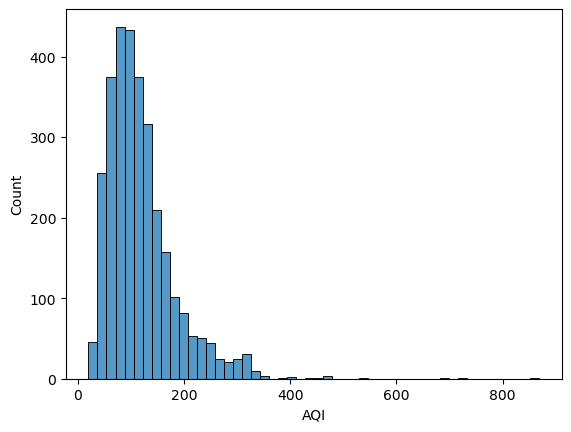

In [ ]:
# Distribution of AQI
sns.histplot(model_data['AQI'], bins=50)

- Implement SMOTER after test/train split

# Model Evaluation Without SMOTER

### Metrics for Evaluation:
- RMSE
- MSE
- R-Squared

In [ ]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Benchmark (Ordinary Least Squares)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize the model
linear_model = LinearRegression()

# Fit the model on the data
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model performance
ols_mse = mean_squared_error(y_test, y_pred)
ols_rmse = np.sqrt(ols_mse)
ols_r2 = r2_score(y_test, y_pred)

# Perform cross-validation
ols_cv = -cross_val_score(linear_model, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_r2 = cross_val_score(linear_model, X, y, cv=5, scoring='r2')
ols_cv_rmse = np.mean(np.sqrt(ols_cv))


print(f"cross validations: {np.mean(ols_cv), ols_cv_rmse, np.mean(ols_cv_r2)}")
print(f"metric eval: {ols_mse, ols_rmse, ols_r2}")

cross validations: (962.3185161247778, 30.177054032795088, 0.7779985003834)
metric eval: (623.6731952159256, 24.97344980606255, 0.8345399439428365)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


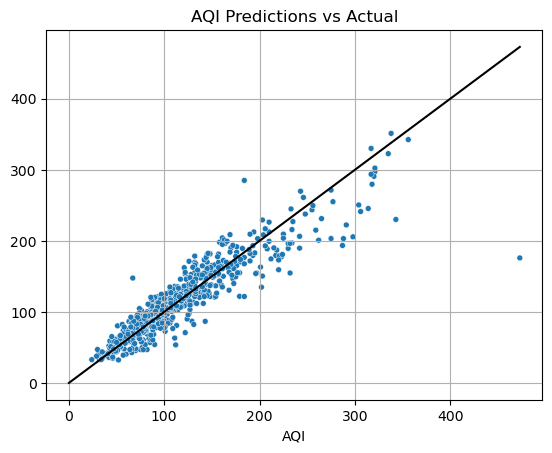

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

# Cross Validate
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')


In [ ]:
# Evaluate Model Performance
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


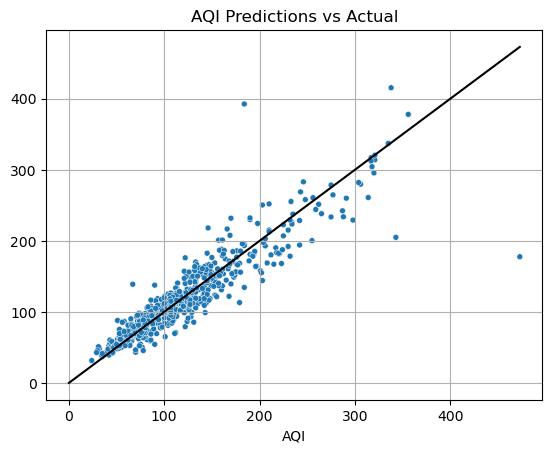

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross val results
rf_results = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)


Best parameters found: {'max_depth': 19, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 84}


In [ ]:
# Evaluate the best model
rf_mse_best = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best = np.sqrt(rf_mse_best)
rf_r2_best = r2_score(y_test, y_pred_best_rf)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


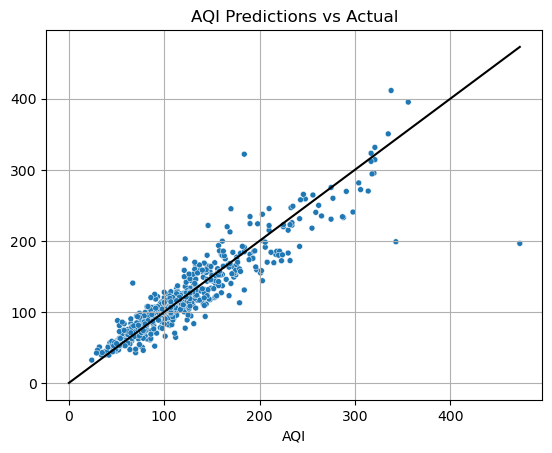

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Support Vector Regression model
svr = SVR(kernel='rbf')  # Using RBF kernel for non-linear relationships
svr.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svr = svr.predict(X_test_scaled)

# Cross Validate
svr_cv = -cross_val_score(svr, scaler.fit_transform(X), y, cv=5, scoring='neg_mean_squared_error')
svr_cv_r2 = cross_val_score(svr, scaler.fit_transform(X), y, cv=5, scoring='r2')


In [ ]:
# Evaluate Model
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(y_test, y_pred_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


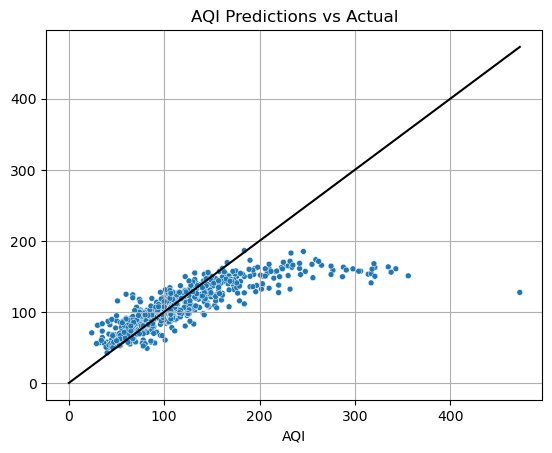

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
from scipy.stats import uniform

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor (SVR)
svr = SVR()

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter between 0.1 and 100
    'epsilon': uniform(0.01, 1),  # Epsilon value for margin
    'gamma': ['scale', 'auto'],  # Gamma parameter for the RBF kernel
    'kernel': ['rbf', 'linear']  # Kernel options
}

# Use RandomizedSearchCV for tuning
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_svr.fit(X_train_scaled, y_train)

# Access cross validation results
svr_results = random_search_svr.cv_results_

# Get the best parameters
best_params_svr = random_search_svr.best_params_
print(f"Best parameters found: {best_params_svr}")

# Use the best model to make predictions
best_svr = random_search_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)



Best parameters found: {'C': 5.908361216819946, 'epsilon': 0.8761761457749352, 'gamma': 'auto', 'kernel': 'linear'}


In [ ]:
# Evaluate the best model
svr_mse_best = mean_squared_error(y_test, y_pred_best_svr)
svr_rmse_best = np.sqrt(svr_mse_best)
svr_r2_best = r2_score(y_test, y_pred_best_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


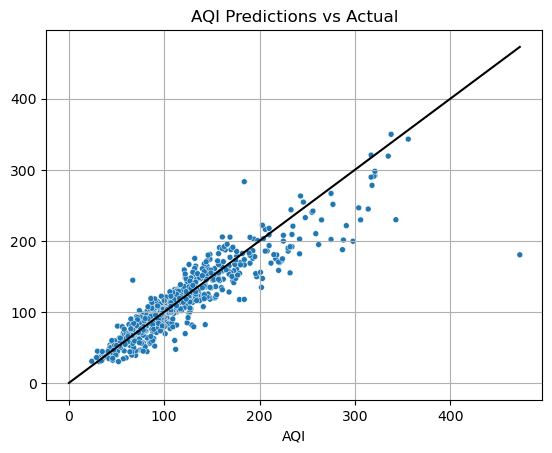

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## XGBoost 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor with default or manually chosen parameters
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Perform cross-validation for MSE and R-squared
xgb_cv_mse = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')



In [ ]:
# Evaluate the Model
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_pred_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


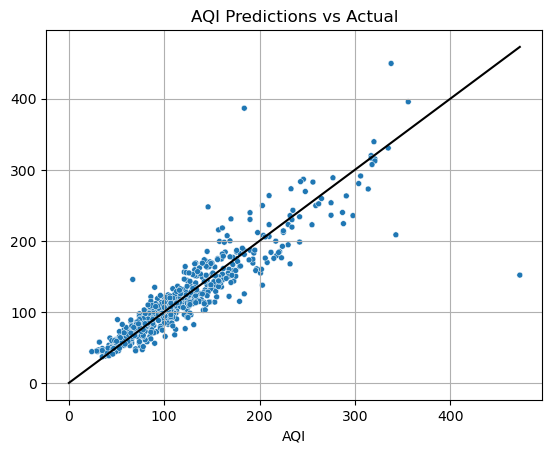

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees (estimators)
    'learning_rate': uniform(0.01, 0.3),  # Learning rate (eta)
    'max_depth': randint(3, 10),  # Depth of trees
    'subsample': uniform(0.5, 0.5),  # Subsampling of rows
    'colsample_bytree': uniform(0.5, 0.5),  # Subsampling of columns
    'reg_alpha': uniform(0, 0.1),  # L1 regularization (alpha)
    'reg_lambda': uniform(0.1, 1.0),  # L2 regularization (lambda)
}

# Use RandomizedSearchCV for tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_xgb.fit(X_train, y_train)

# Access cross validation results
xgb_results = random_search_xgb.cv_results_

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters found: {best_params_xgb}")

# Use the best model to make predictions
best_xgb = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

Best parameters found: {'colsample_bytree': 0.9534142207728771, 'learning_rate': 0.09163967481539059, 'max_depth': 5, 'n_estimators': 170, 'reg_alpha': 0.08180147659224932, 'reg_lambda': 0.9607305832563434, 'subsample': 0.5034760652655954}


In [ ]:
# Evaluate the Model
xgb_mse_best = mean_squared_error(y_test, y_pred_best_xgb)
xgb_rmse_best = np.sqrt(xgb_mse_best)
xgb_r2_best = r2_score(y_test, y_pred_best_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


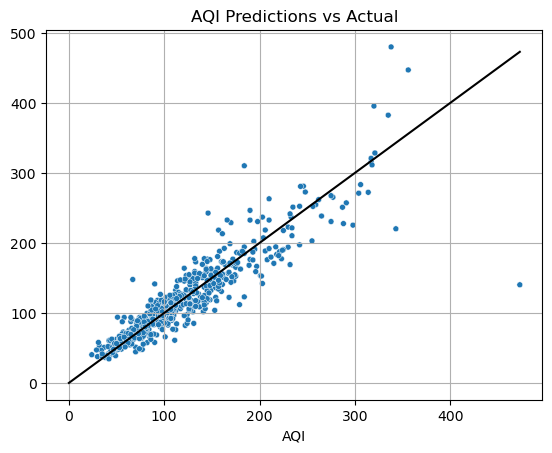

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Stacked Neural Network + XGBoost

In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

# Initialize XGBoost and Neural Network as base learners
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=5000, random_state=42)

# Create the stacking model using Linear Regression as the meta-model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_stacked = stacked_model.predict(X_test)

hybrid_cv = cross_val_score(stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
hybrid_cv_r2 = cross_val_score(stacked_model, X, y, cv=5, scoring='r2')


In [ ]:
# Evaluate the Model
stacked_mse = mean_squared_error(y_test, y_pred_stacked)
stacked_rmse = np.sqrt(stacked_mse)
stacked_r2 = r2_score(y_test, y_pred_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


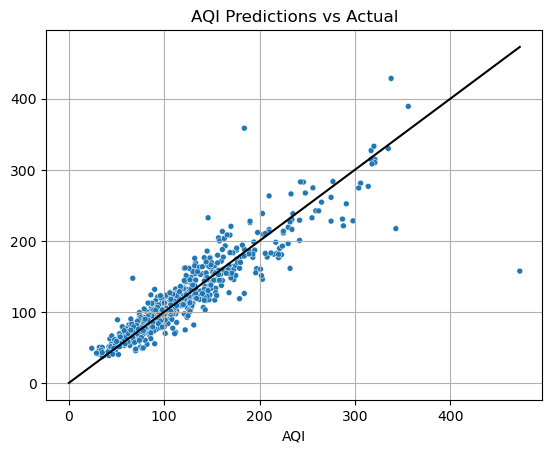

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomSearch

In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint

# Initialize base models
xgb_model = xgb.XGBRegressor(random_state=42)
nn_model = MLPRegressor(max_iter=5000, random_state=42, verbose=False)

# Define the stacking model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__subsample': uniform(0.5, 0.5),  # Generates values strictly between 0.5 and 1.0
    'xgb__colsample_bytree': uniform(0.5, 0.5),  # Same, strictly between 0.5 and 1.0
    
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'nn__activation': ['relu'],
    'nn__alpha': uniform(0.0001, 0.01),  # Reasonable regularization range
    'nn__solver': ['adam']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=stacked_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error',
                                   random_state=42, 
                                   n_jobs=1,  # No parallel jobs
                                   error_score='raise')  # Raise errors

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross-validation results
stacked_restults = random_search.cv_results_

# Get the best parameters and best model
best_stacked_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Make predictions and evaluate the tuned stacked model
y_pred_best_stacked = best_stacked_model.predict(X_test)


Best parameters found: {'nn__activation': 'relu', 'nn__alpha': 0.002284404372168336, 'nn__hidden_layer_sizes': (100,), 'nn__solver': 'adam', 'xgb__colsample_bytree': 0.9416401294594341, 'xgb__learning_rate': 0.10730350630158218, 'xgb__max_depth': 9, 'xgb__n_estimators': 141, 'xgb__subsample': 0.6781489190384875}


In [ ]:
# Evaluate the model
stacked_mse_best = mean_squared_error(y_test, y_pred_best_stacked)
stacked_rmse_best = np.sqrt(stacked_mse_best)
stacked_r2_best = r2_score(y_test, y_pred_best_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


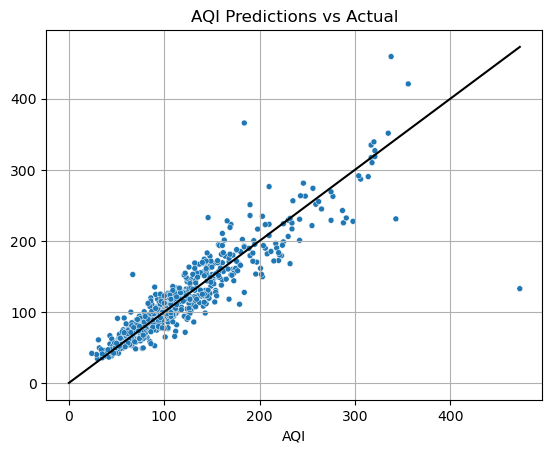

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

# Model Comparisons

In [ ]:
from scipy.stats import f_oneway

rf_results_mse = rf_results['mean_test_score']
svr_results_mse = svr_results['mean_test_score']
xgb_results_mse = xgb_results['mean_test_score']
stacked_restults_mse = stacked_restults['mean_test_score']

# Perform ANOVA test
f_statistic, p_value = f_oneway(rf_results_mse, svr_results_mse, xgb_results_mse, stacked_restults_mse)

# Output the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretation of ANOVA test result
if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("No statistically significant difference between the models.")


F-statistic: 21.01878050030217
P-value: 5.14155594925782e-10
There is a statistically significant difference between the models.


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example MSE data for three models
# Replace with your cross-validated MSE data
mse_data = np.concatenate([rf_results_mse, svr_results_mse, xgb_results_mse, stacked_restults_mse])

# Corresponding labels for the models
model_labels = (['Random Forest'] * len(rf_results_mse)) + (['SVG'] * len(svr_results_mse)) + (['XGBoost'] * len(xgb_results_mse) + (['Hybrid Model'] * len(stacked_restults_mse)))

# Create a DataFrame to hold the MSE values and corresponding model labels
df = pd.DataFrame({'MSE': mse_data, 'Model': model_labels})

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['MSE'], groups=df['Model'], alpha=0.05)

# Display the test results
print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------
 Hybrid Model Random Forest -169.6503    0.0  -245.949 -93.3516   True
 Hybrid Model           SVG -135.5595 0.0001 -211.8582 -59.2608   True
 Hybrid Model       XGBoost   16.5474 0.9408  -59.7513  92.8461  False
Random Forest           SVG   34.0907 0.6452   -42.208 110.3894  False
Random Forest       XGBoost  186.1976    0.0  109.8989 262.4963   True
          SVG       XGBoost  152.1069    0.0   75.8082 228.4056   True
----------------------------------------------------------------------


In [ ]:
# Dataframe for Metric Comparison without SMOTER

models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']
mse = [ols_mse, rf_mse_best, svr_mse_best, xgb_mse_best, stacked_mse_best]
rmse = [ols_rmse, rf_rmse_best, svr_rmse_best, xgb_rmse_best, stacked_rmse_best]
r2 = [ols_r2, rf_r2_best, svr_r2_best, xgb_r2_best, stacked_r2_best]

# Create the DataFrame
metric_comparison = pd.DataFrame({
    'Model': models,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2
}, index = models)

# Display the DataFrame
metric_comparison

,Model,MSE,RMSE,R²
OLS,OLS,623.673195,24.973450,0.834540
Random Forest,Random Forest,547.709968,23.403204,0.854693
SVR,SVR,630.932471,25.118369,0.832614
XGB,XGB,678.872645,26.055185,0.819896
XGB + NN,XGB + NN,674.147256,25.964346,0.821149


## Cross Validation Comparison

In [ ]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# XGBoost + NN
stacked_mse_cv = -cross_val_score(best_stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
stacked_r2_cv = cross_val_score(best_stacked_model, X, y, cv=5, scoring='r2')

# RF
rf_mse_cv = -cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_r2_cv = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

# SVR
svr_r2_cv = cross_val_score(best_svr, X, y, cv=5, scoring='r2', n_jobs=-1)
svr_mse_cv = -cross_val_score(best_svr, X, y, cv=5, scoring='neg_mean_squared_error')

# XGBoost
xgb_r2_cv = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')
xgb_mse_cv = -cross_val_score(best_xgb, X, y, cv=5, scoring='neg_mean_squared_error')

# Average MSE
avg_mse_cv = [np.mean(ols_cv),np.mean(rf_mse_cv),np.mean(svr_mse_cv),np.mean(xgb_mse_cv),np.mean(stacked_mse_cv)]

# Average RMSE
avg_rmse_cv = [ols_cv_rmse,np.mean(np.sqrt(rf_mse_cv)),np.mean(np.sqrt(svr_mse_cv)),np.mean(np.sqrt(xgb_mse_cv)),np.mean(np.sqrt(stacked_mse_cv))]

# Average R2
avg_r2_cv = [np.mean(ols_cv_r2),np.mean(rf_r2_cv),np.mean(svr_r2_cv),np.mean(xgb_r2_cv),np.mean(stacked_r2_cv)]

In [ ]:
# CV dataframe

cv_models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']

cv_results = pd.DataFrame({
    'Models': cv_models,
    'MSE': avg_mse_cv,
    'RMSE': avg_rmse_cv,
    'R²': avg_r2_cv
})

cv_results

,Models,MSE,RMSE,R²
0,OLS,962.318516,30.177054,0.777999
1,Random Forest,899.687922,29.120207,0.792546
2,SVR,889.057177,29.122742,0.793288
3,XGB,951.225256,30.035775,0.776037
4,XGB + NN,911.927377,29.360233,0.790896


# Model Evaluation with SMOTER

- Below needs to be rerun until it works

In [ ]:
import smogn

X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Done previously

# Resample using higher values K on training set
X_train_resample = X_train.reset_index(drop=True)
y_train_resample = y_train.reset_index(drop=True)

train_resampled = pd.concat([X_train_resample, y_train_resample], axis=1)
train_resampled = smogn.smoter(train_resampled, y='AQI', k=5, samp_method='extreme')

# Split the resampled data back into features and target
X_resampled = train_resampled.drop(columns='AQI', axis=1)
y_resampled = train_resampled['AQI']

dist_matrix:   1%|1         | 4/363 [00:00<00:08, 39.97it/s]

r_index: 100%|##########| 254/254 [00:00<00:00, 2918.34it/s]


In [ ]:
print(X_resampled.shape, X_train.shape)

(3737, 12) (2448, 12)


## Benchmark (Ordinary Least Squares)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize the model
linear_model_smoter = LinearRegression()

# Fit the model on the data
linear_model_smoter.fit(X_resampled, y_resampled)

# Make predictions
y_pred_smoter = linear_model_smoter.predict(X_test)

# Evaluate the model performance
ols_mse_smoter = mean_squared_error(y_test, y_pred_smoter)
ols_rmse_smoter = np.sqrt(ols_mse_smoter)
ols_r2_smoter = r2_score(y_test, y_pred_smoter)

# Perform cross-validation
ols_cv_smoter = -cross_val_score(linear_model_smoter, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_r2_smoter = cross_val_score(linear_model_smoter, X, y, cv=5, scoring='r2')
ols_cv_rmse_smoter = np.mean(np.sqrt(ols_cv_smoter))

print(f"cross validations: {np.mean(ols_cv_smoter), ols_cv_rmse_smoter, np.mean(ols_cv_r2_smoter)}")
print(f"metric eval: {ols_mse_smoter, ols_rmse_smoter, ols_r2_smoter}")

cross validations: (962.3185161247778, 30.177054032795088, 0.7779985003834)
metric eval: (678.9597599419399, 26.056856294302655, 0.8198724575590306)


- Cross validation yields the same results due to the nature of cross_val_score. We need to resample only the training data during the kfolds

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


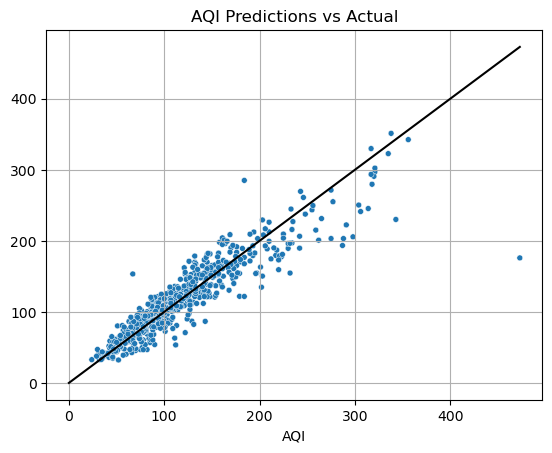

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

# Cross Validate
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')



In [ ]:
# Evaluate Model Performance
rf_mse_smoter = mean_squared_error(y_test, y_pred_rf)
rf_rmse_smoter = np.sqrt(rf_mse_smoter)
rf_r2_smoter = r2_score(y_test, y_pred_rf)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


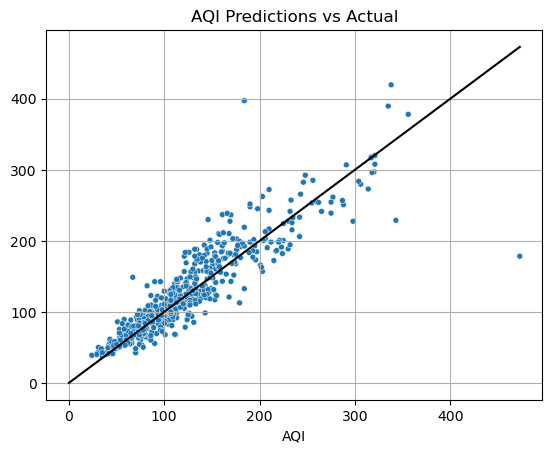

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)

# Access cross val results
rf_results_smoter = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

Best parameters found: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


In [ ]:
# Evaluate the best model
rf_mse_best_smoter = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best_smoter = np.sqrt(rf_mse_best_smoter)
rf_r2_best_smoter = r2_score(y_test, y_pred_best_rf)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


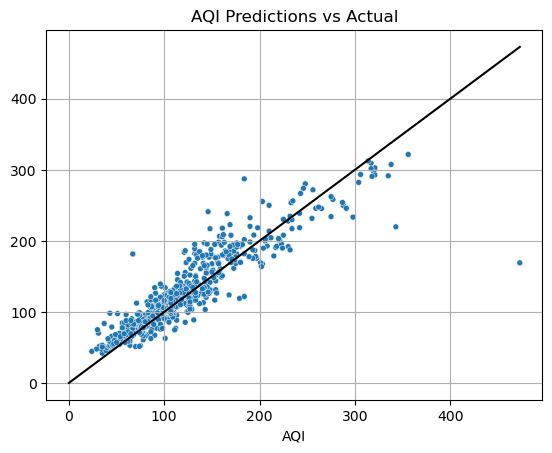

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Support Vector Regression model
svr = SVR(kernel='rbf')  # Using RBF kernel for non-linear relationships
svr.fit(X_train_scaled, y_resampled)

# Predict and evaluate
y_pred_svr = svr.predict(X_test_scaled)

# Cross Validate
svr_cv = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')
svr_cv_r2 = cross_val_score(svr, X, y, cv=5, scoring='r2')

In [ ]:
# Evaluate Model
svr_mse_smoter = mean_squared_error(y_test, y_pred_svr)
svr_rmse_smoter = np.sqrt(svr_mse_smoter)
svr_r2_smoter = r2_score(y_test, y_pred_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


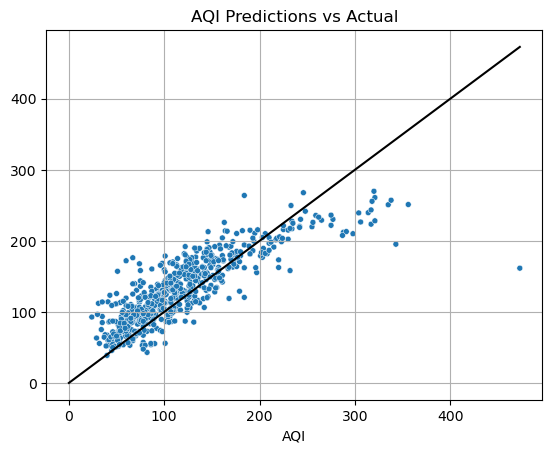

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
from scipy.stats import uniform

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor (SVR)
svr = SVR()

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter between 0.1 and 100
    'epsilon': uniform(0.01, 1),  # Epsilon value for margin
    'gamma': ['scale', 'auto'],  # Gamma parameter for the RBF kernel
    'kernel': ['rbf', 'linear']  # Kernel options
}

# Use RandomizedSearchCV for tuning
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_svr.fit(X_train_scaled, y_resampled)

# Access cross validation results
svr_results_smoter = random_search_svr.cv_results_

# Get the best parameters
best_params_svr = random_search_svr.best_params_
print(f"Best parameters found: {best_params_svr}")

# Use the best model to make predictions
best_svr = random_search_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)


Best parameters found: {'C': 45.706998421703595, 'epsilon': 0.7951759613930136, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
# Evaluate the best model
svr_mse_best_smoter = mean_squared_error(y_test, y_pred_best_svr)
svr_rmse_best_smoter = np.sqrt(svr_mse_best_smoter)
svr_r2_best_smoter = r2_score(y_test, y_pred_best_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


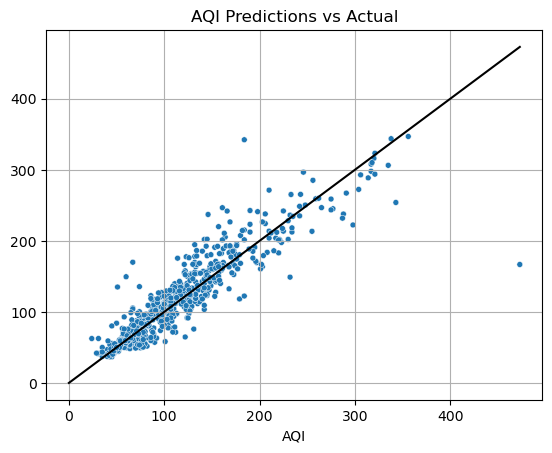

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor with default or manually chosen parameters
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Perform cross-validation for MSE and R-squared
xgb_cv_mse = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')

In [ ]:
# Evaluate the Model
xgb_mse_smoter = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse_smoter = np.sqrt(xgb_mse_smoter)
xgb_r2_smoter = r2_score(y_test, y_pred_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


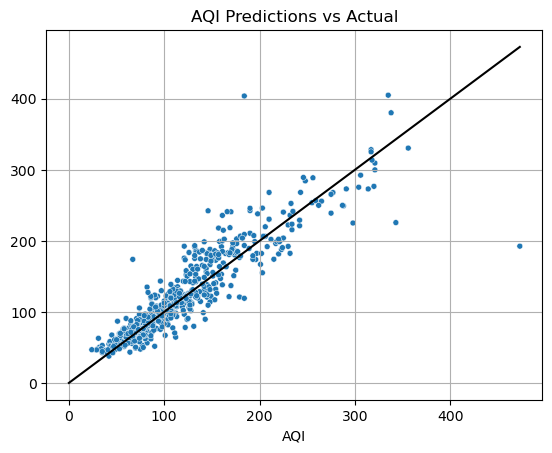

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees (estimators)
    'learning_rate': uniform(0.01, 0.3),  # Learning rate (eta)
    'max_depth': randint(3, 10),  # Depth of trees
    'subsample': uniform(0.5, 0.5),  # Subsampling of rows
    'colsample_bytree': uniform(0.5, 0.5),  # Subsampling of columns
    'reg_alpha': uniform(0, 0.1),  # L1 regularization (alpha)
    'reg_lambda': uniform(0.1, 1.0),  # L2 regularization (lambda)
}

# Use RandomizedSearchCV for tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_xgb.fit(X_resampled, y_resampled)

# Access cross validation results
xgb_results_smoter = random_search_xgb.cv_results_

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters found: {best_params_xgb}")

# Use the best model to make predictions
best_xgb = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

Best parameters found: {'colsample_bytree': 0.8182052056318903, 'learning_rate': 0.104306794322898, 'max_depth': 6, 'n_estimators': 192, 'reg_alpha': 0.07555511385430487, 'reg_lambda': 0.32879816549162244, 'subsample': 0.5384899549143964}


In [ ]:
# Evaluate the Model
xgb_mse_best_smoter = mean_squared_error(y_test, y_pred_best_xgb)
xgb_rmse_best_smoter = np.sqrt(xgb_mse_best_smoter)
xgb_r2_best_smoter = r2_score(y_test, y_pred_best_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


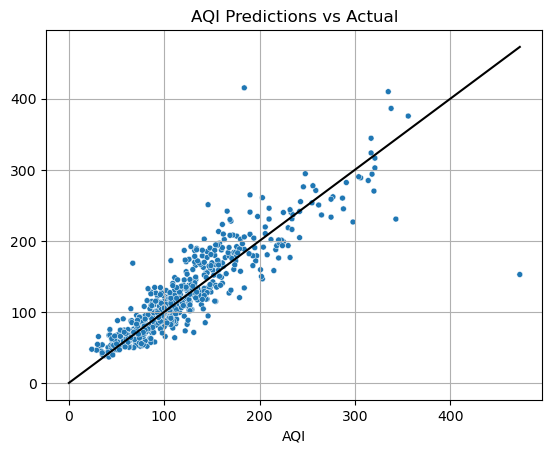

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Stacked Neural Network + XGBoost

In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

# Initialize XGBoost and Neural Network as base learners
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=5000, random_state=42)

# Create the stacking model using Linear Regression as the meta-model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Fit the stacked model
stacked_model.fit(X_resampled, y_resampled)

# Make predictions and evaluate the model
y_pred_stacked = stacked_model.predict(X_test)

hybrid_cv = cross_val_score(stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
hybrid_cv_r2 = cross_val_score(stacked_model, X, y, cv=5, scoring='r2')


In [ ]:
# Evaluate the Model
stacked_mse_smoter = mean_squared_error(y_test, y_pred_stacked)
stacked_rmse_smoter = np.sqrt(stacked_mse_smoter)
stacked_r2_smoter = r2_score(y_test, y_pred_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


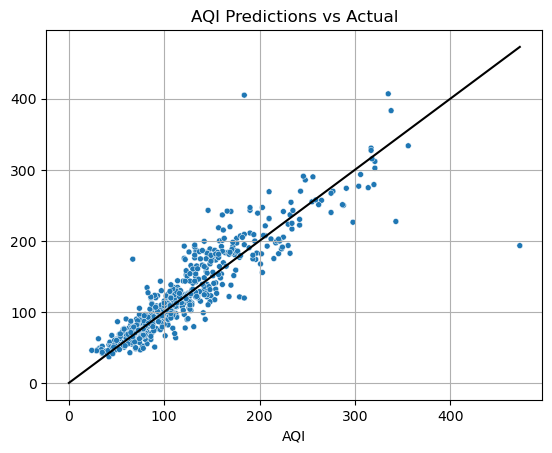

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint

# Initialize base models
xgb_model = xgb.XGBRegressor(random_state=42)
nn_model = MLPRegressor(max_iter=5000, random_state=42, verbose=False)

# Define the stacking model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__subsample': uniform(0.5, 0.5),  # Generates values strictly between 0.5 and 1.0
    'xgb__colsample_bytree': uniform(0.5, 0.5),  # Same, strictly between 0.5 and 1.0
    
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'nn__activation': ['relu'],
    'nn__alpha': uniform(0.0001, 0.01),  # Reasonable regularization range
    'nn__solver': ['adam']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=stacked_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error',
                                   random_state=42, 
                                   n_jobs=1,  # No parallel jobs
                                   error_score='raise')  # Raise errors

# Fit the random search model
random_search.fit(X_resampled, y_resampled)

# Access cross-validation results
stacked_restults_smoter = random_search.cv_results_

# Get the best parameters and best model
best_stacked_model_smote = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Make predictions and evaluate the tuned stacked model
y_pred_best_stacked = best_stacked_model_smote.predict(X_test)



Best parameters found: {'nn__activation': 'relu', 'nn__alpha': 0.00025636406741193934, 'nn__hidden_layer_sizes': (50,), 'nn__solver': 'adam', 'xgb__colsample_bytree': 0.8861223846483287, 'xgb__learning_rate': 0.06961470446025171, 'xgb__max_depth': 9, 'xgb__n_estimators': 188, 'xgb__subsample': 0.5994212020444025}


In [ ]:
# Evaluate the model
stacked_mse_best_smoter = mean_squared_error(y_test, y_pred_best_stacked)
stacked_rmse_best_smoter = np.sqrt(stacked_mse_best_smoter)
stacked_r2_best_smoter = r2_score(y_test, y_pred_best_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


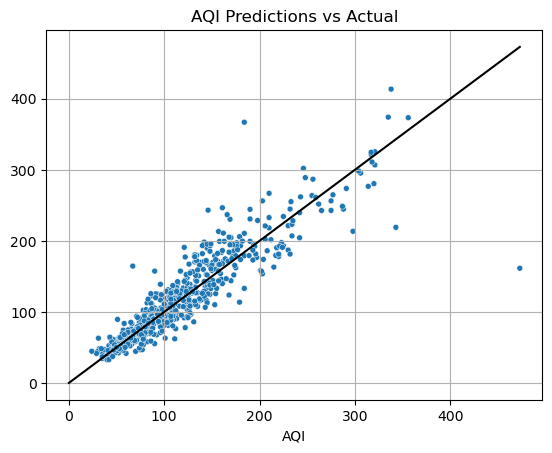

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

# Model Comparisons

In [ ]:
from scipy.stats import f_oneway

rf_results_mse_smoter = rf_results_smoter['mean_test_score']
svr_results_mse_smoter = svr_results_smoter['mean_test_score']
xgb_results_mse_smoter = xgb_results_smoter['mean_test_score']
stacked_restults_mse_smoter = stacked_restults_smoter['mean_test_score']

# Perform ANOVA test
f_statistic, p_value = f_oneway(rf_results_mse_smoter, svr_results_mse_smoter, xgb_results_mse_smoter, stacked_restults_mse_smoter)

# Output the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretation of ANOVA test result
if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("No statistically significant difference between the models.")

F-statistic: 51.35064082998433
P-value: 3.0462903371592707e-18
There is a statistically significant difference between the models.


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example MSE data for three models
# Replace with your cross-validated MSE data
mse_data = np.concatenate([rf_results_mse_smoter, svr_results_mse_smoter, xgb_results_mse_smoter, stacked_restults_mse_smoter])

# Corresponding labels for the models
model_labels = (['Random Forest'] * len(rf_results_mse_smoter)) + (['SVG'] * len(svr_results_mse_smoter)) + (['XGBoost'] * len(xgb_results_mse_smoter) + (['Hybrid Model'] * len(stacked_restults_mse_smoter)))

# Create a DataFrame to hold the MSE values and corresponding model labels
df = pd.DataFrame({'MSE': mse_data, 'Model': model_labels})

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['MSE'], groups=df['Model'], alpha=0.05)

# Display the test results
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
 Hybrid Model Random Forest -534.7397    0.0  -707.501 -361.9783   True
 Hybrid Model           SVG -603.5797    0.0  -776.341 -430.8183   True
 Hybrid Model       XGBoost   11.8785 0.9979 -160.8828  184.6399  False
Random Forest           SVG    -68.84 0.7226 -241.6013  103.9214  False
Random Forest       XGBoost  546.6182    0.0  373.8569  719.3796   True
          SVG       XGBoost  615.4582    0.0  442.6969  788.2196   True
-----------------------------------------------------------------------


In [ ]:
# Dataframe for Metric Comparison without SMOTER

models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']
mse_smoter = [ols_mse_smoter, rf_mse_best_smoter, svr_mse_best_smoter, xgb_mse_best_smoter, stacked_mse_best_smoter]
rmse_smoter = [ols_rmse_smoter, rf_rmse_best_smoter, svr_rmse_best_smoter, xgb_rmse_best_smoter, stacked_rmse_best_smoter]
r2_smoter = [ols_r2_smoter, rf_r2_best_smoter, svr_r2_best_smoter, xgb_r2_best_smoter, stacked_r2_best_smoter]

# Create the DataFrame
metric_comparison_smoter = pd.DataFrame({
    'Model': models,
    'MSE': mse_smoter,
    'RMSE': rmse_smoter,
    'R²': r2_smoter
})

# Display the DataFrame
metric_comparison_smoter

,Model,MSE,RMSE,R²
0,OLS,694.562850,26.354560,0.815733
1,Random Forest,659.290462,25.676652,0.825091
2,SVR,692.654866,26.318337,0.816239
3,XGB,789.735879,28.102240,0.790484
4,XGB + NN,714.120237,26.723028,0.810544


## Cross Validation Comparison

In [ ]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Hybrid
stacked_mse_cv_smote = -cross_val_score(best_stacked_model_smote, X, y, cv=5, scoring='neg_mean_squared_error')
stacked_r2_cv_smote = cross_val_score(best_stacked_model_smote, X, y, cv=5, scoring='r2')

# RF
rf_mse_cv_smote = -cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_r2_cv_smote = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

# SVR
svr_r2_cv_smote = cross_val_score(best_svr, X, y, cv=5, scoring='r2')
svr_mse_cv_smote = -cross_val_score(best_svr, X, y, cv=5, scoring='neg_mean_squared_error')

# XGBoost
xgb_r2_cv_smote = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')
xgb_mse_cv_smote = -cross_val_score(best_xgb, X, y, cv=5, scoring='neg_mean_squared_error')

# Average MSE
avg_mse_cv_smote = [np.mean(ols_cv_smoter),np.mean(rf_mse_cv_smote),np.mean(svr_mse_cv_smote),np.mean(xgb_mse_cv_smote),np.mean(stacked_mse_cv_smote)]

# Average RMSE
avg_rmse_cv_smote = [ols_cv_rmse_smoter,np.mean(np.sqrt(rf_mse_cv_smote)),np.mean(np.sqrt(svr_mse_cv_smote)),np.mean(np.sqrt(xgb_mse_cv_smote)),np.mean(np.sqrt(stacked_mse_cv_smote))]

# Average R2
avg_r2_cv_smote = [np.mean(ols_cv_r2_smoter),np.mean(rf_r2_cv_smote),np.mean(svr_r2_cv_smote),np.mean(xgb_r2_cv_smote),np.mean(stacked_r2_cv_smote),]

In [ ]:
svr_r2_cv_smote = cross_val_score(best_svr, X, y, cv=5, scoring='r2')
svr_mse_cv_smote = -cross_val_score(best_svr, X, y, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# CV dataframe

cv_models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']

cv_results_smoter = pd.DataFrame({
    'Models': cv_models,
    'MSE': avg_mse_cv_smote,
    'RMSE': avg_rmse_cv_smote,
    'R²': avg_r2_cv_smote
})

cv_results_smoter

,Models,MSE,RMSE,R²
0,OLS,989.542433,30.579926,0.779323
1,Random Forest,1113.656743,32.105269,0.744975
2,SVR,1266.956858,34.466166,0.709069
3,XGB,998.809312,30.865088,0.764111
4,XGB + NN,893.197991,29.324813,0.787514


# SMOTE vs Without SMOTE

In [ ]:
# Models (row index)
models = ['OLS', 'Random Forest', 'SVR', 'XGBoost', 'XGBoost + NN']

# Create MultiIndex for columns
multi_column_index = pd.MultiIndex.from_product(
    [['Without SMOTER', 'With SMOTER'], ['MSE', 'RMSE', 'R²']],
    names=['Condition', 'Metric']
)

# Create the DataFrame with hierarchical columns
metric_comparison_combined = pd.DataFrame({
    ('Without SMOTER', 'MSE'): mse,
    ('Without SMOTER', 'RMSE'): rmse,
    ('Without SMOTER', 'R²'): r2,
    ('With SMOTER', 'MSE'): mse_smoter,
    ('With SMOTER', 'RMSE'): rmse_smoter,
    ('With SMOTER', 'R²'): r2_smoter
}, index=models)

# Display the combined DataFrame
metric_comparison_combined


Without SMOTER                      With SMOTER             \
                         MSE       RMSE        R²         MSE       RMSE   
OLS               625.172537  25.003451  0.834142  694.562850  26.354560   
Random Forest     554.033307  23.537912  0.853015  659.290462  25.676652   
SVR               632.078481  25.141171  0.832310  692.654866  26.318337   
XGBoost           721.018115  26.851780  0.808714  789.735879  28.102240   
XGBoost + NN      632.127100  25.142138  0.832297  714.120237  26.723028   

                         
                     R²  
OLS            0.815733  
Random Forest  0.825091  
SVR            0.816239  
XGBoost        0.790484  
XGBoost + NN   0.810544

# Cross Validation SMOTER Comparison

In [ ]:
# Models (row index)
models = ['OLS', 'Random Forest', 'SVR', 'XGBoost', 'XGBoost + NN']

# Create MultiIndex for columns
multi_column_index = pd.MultiIndex.from_product(
    [['Without SMOTER', 'With SMOTER'], ['MSE', 'RMSE', 'R²']],
    names=['Condition', 'Metric']
)

# Create the DataFrame with hierarchical columns
cv_results_combined = pd.DataFrame({
    ('Without SMOTER', 'MSE'): avg_mse_cv,
    ('Without SMOTER', 'RMSE'): avg_rmse_cv,
    ('Without SMOTER', 'R²'): avg_r2_cv,
    ('With SMOTER', 'MSE'): avg_mse_cv_smote,
    ('With SMOTER', 'RMSE'): avg_rmse_cv_smote,
    ('With SMOTER', 'R²'): avg_r2_cv_smote
}, index=models)

# Display the combined DataFrame
cv_results_combined


Without SMOTER                       With SMOTER             \
                         MSE       RMSE        R²          MSE       RMSE   
OLS               963.262419  30.185302  0.777955   989.542433  30.579926   
Random Forest     900.274859  29.137171  0.792407  1113.656743  32.105269   
SVR               880.394051  28.941931  0.796285  1266.956858  34.466166   
XGBoost           985.914763  30.548913  0.769005   998.809312  30.865088   
XGBoost + NN      913.856143  29.401056  0.790338   893.197991  29.324813   

                         
                     R²  
OLS            0.779323  
Random Forest  0.744975  
SVR            0.709069  
XGBoost        0.764111  
XGBoost + NN   0.787514

## Cross Validation for OLS with different Number of Folds

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
linear_model = LinearRegression()

# Fit the model on the data
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Perform cross-validation
for i in range(2,10):
      ols_cv_test = -cross_val_score(linear_model, X, y, cv=i, scoring='neg_mean_squared_error')
      ols_cv_r2_test = cross_val_score(linear_model, X, y, cv=i, scoring='r2')
      ols_cv_rmse_test = np.mean(np.sqrt(ols_cv_test))

      print(f"R-Squared: {np.mean(ols_cv_r2_test)}")

print(f"MSE: {np.mean(ols_cv_test)}\n"
      f"RMSE: {ols_cv_rmse_test}\n"
      f"R-Squared: {np.mean(ols_cv_r2_test)}")

R-Squared: 0.7683192369969554
R-Squared: 0.7209273940956846


R-Squared: 0.782040584038667
R-Squared: 0.7779554385254358
R-Squared: 0.6711931375270477
R-Squared: 0.7755254857657133
R-Squared: 0.7716142313632894
R-Squared: 0.6813773973943048
MSE: 958.6245569588785
RMSE: 29.30429811162654
R-Squared: 0.6813773973943048


# Export to .csv

In [ ]:
# Export to cs

cv_results_combined.to_csv('Cross_Validation_Results.csv', index=True)
metric_comparison_combined.to_csv('Model_Metric_Results.csv', index=True)

# Addressing Increased MSE

## SMOTE Variations

- Look as Residuals
- Investigate the K nearest neighbours used in SMOTER & Sampling Method

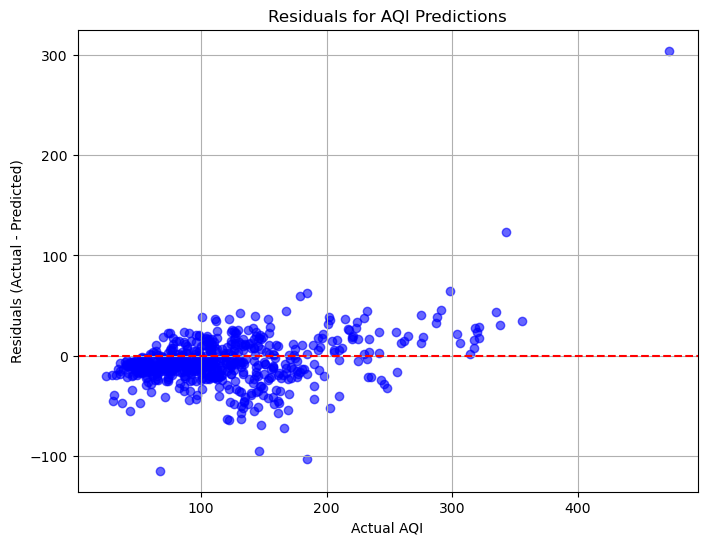

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_rf

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions')
plt.grid(True)
plt.show()


In [ ]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Resample using higher values K on training set
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

train_resampled = pd.concat([X_train, y_train], axis=1)
train_resampled = smogn.smoter(train_resampled, y='AQI', k=5, samp_method='extreme')

# Split the resampled data back into features and target
X_resampled = train_resampled.drop(columns='AQI', axis=1)
y_resampled = train_resampled['AQI']

r_index: 100%|##########| 254/254 [00:00<00:00, 2824.48it/s]


ValueError: oops! synthetic data contains missing values

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AQI', ylabel='Count'>

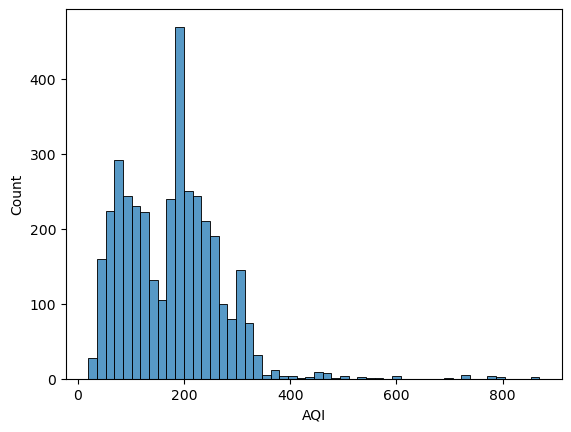

In [ ]:
# Distribution of AQI
sns.histplot(y_resampled)

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)

# Access cross val results
rf_results_smoter = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

Best parameters found: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


In [ ]:
# Evaluate the best model
rf_mse_best_smoter = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best_smoter = np.sqrt(rf_mse_best_smoter)
rf_r2_best_smoter = r2_score(y_test, y_pred_best_rf)

print(f"Evaluation of the Best Random Forest Model with SMOTER:\n"
      f"MSE: {rf_mse_best_smoter:.2f}\n"
      f"RMSE: {rf_rmse_best_smoter:.2f}\n"
      f"R²: {rf_r2_best_smoter:.4f}")

Evaluation of the Best Random Forest Model with SMOTER:
MSE: 673.31
RMSE: 25.95
R²: 0.8214


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


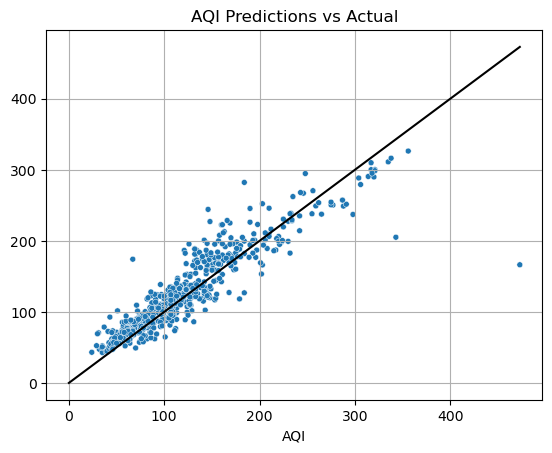

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

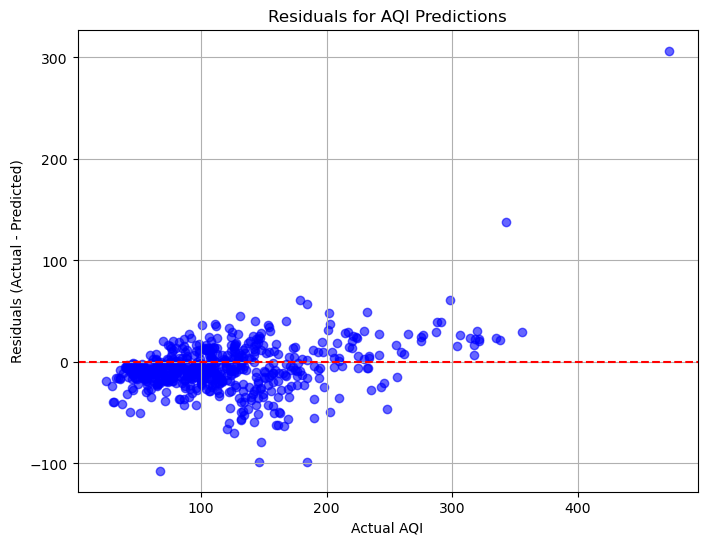

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_rf

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions')
plt.grid(True)
plt.show()

In [ ]:
# Cross Validate again to check for overfitting
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')

print(f"Average MSE {-np.mean(rf_cv)}\n"
      f"Cross Validation R-Square {np.mean(rf_cv_r2)}")

Average MSE 930.755190375044
Cross Validation R-Square 0.7827185901678249


## Residuals

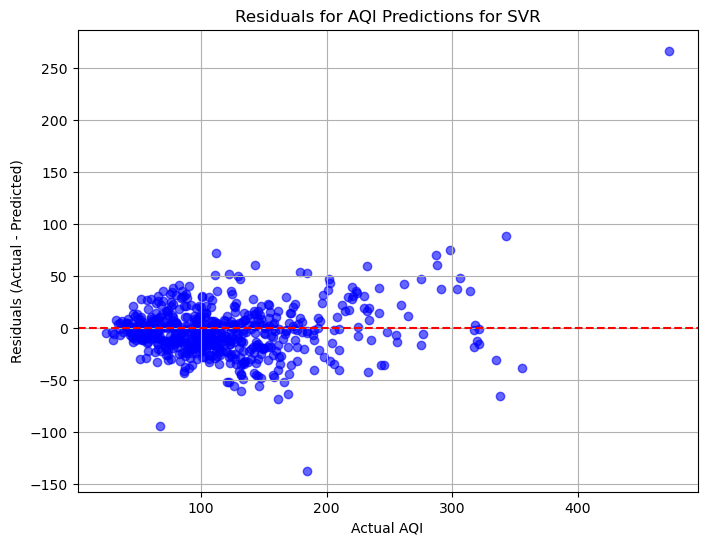

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_svr

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for SVR')
plt.grid(True)
plt.show()

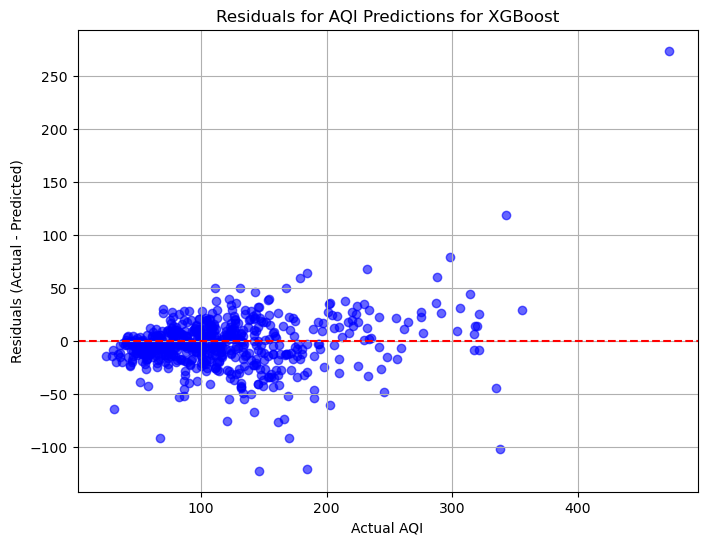

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_xgb

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for XGBoost')
plt.grid(True)
plt.show()

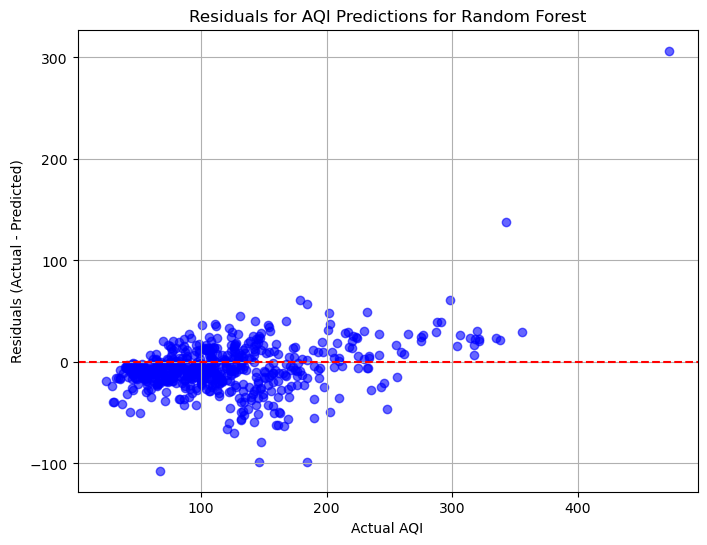

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_rf

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for Random Forest')
plt.grid(True)
plt.show()

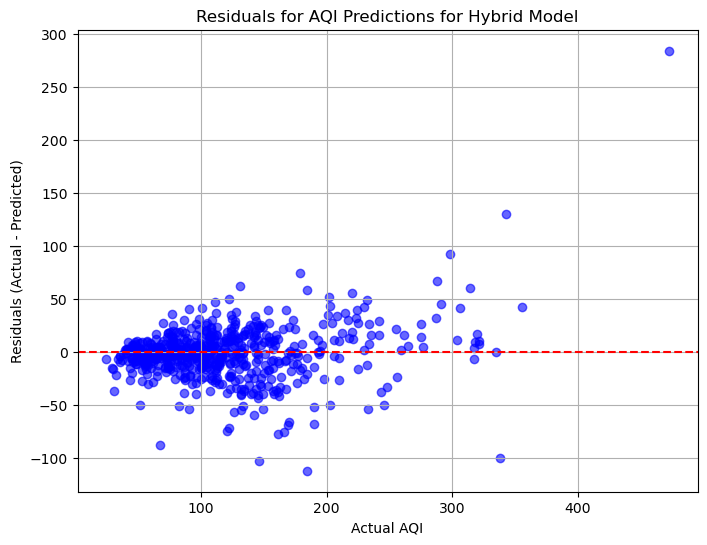

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_stacked

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for Hybrid Model')
plt.grid(True)
plt.show()

# Additional Plots

# Metric Evalutation vs Cross Validation

In [ ]:
# Models (row index)
models = ['OLS', 'Random Forest', 'SVR', 'XGBoost', 'XGBoost + NN']

# Create MultiIndex for columns
multi_column_index = pd.MultiIndex.from_product(
    [['Metric Evaluation', 'Cross Validation'], ['MSE', 'RMSE', 'R²']],
    names=['Condition', 'Metric']
)

# Create the DataFrame with hierarchical columns
model_comparison = pd.DataFrame({
    ('Metric Evaluation', 'MSE'): mse,
    ('Metric Evaluation', 'RMSE'): rmse,
    ('Metric Evaluation', 'R²'): r2,
    ('Cross Validation', 'MSE'): avg_mse_cv,
    ('Cross Validation', 'RMSE'): avg_rmse_cv,
    ('Cross Validation', 'R²'): avg_r2_cv
}, index=models)

# Display the combined DataFrame
model_comparison

model_comparison.to_csv('model_comparison.csv', index=True)